# Downloading Data

In [1]:
%%bash

# checking if kaggle API is configured

if [ ! -d ~/.kaggle/ ]; then

    echo "Kaggle credentials are not configured"

else

    echo "Kaggle API is already configured"

fi

Kaggle API is already configured


In [5]:
%%bash

# checking if data is downloaded

if [ ! -d data/ ]; then

  echo "Downloading dataset..."
  kaggle competitions download dogs-vs-cats-redux-kernels-edition
  
  mkdir data/

  echo "Unzipping datasets"
  unzip -qq dogs-vs-cats-redux-kernels-edition.zip
  unzip -qq test.zip -d data/
  unzip -qq train.zip -d data/
  
  mv sample_submission.csv data/
  
  rm -rf test.zip train.zip dogs-vs-cats-redux-kernels-edition.zip

else

  echo "Dataset already dataset downloaded."

fi


Unzipping datasets


100%|██████████| 814M/814M [00:17<00:00, 48.6MB/s]


In [15]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Tensorflow version is", tf.__version__)

BASE_DIR=os.getcwd()+'/data/'

TRAIN_DIR = BASE_DIR + "train/"
TEST_DIR = BASE_DIR + "test/"

TRAIN_SIZE = len([name for name in os.listdir(TRAIN_DIR)])
TEST_SIZE = len([name for name in os.listdir(TEST_DIR)])
print("Number of training images:", TRAIN_SIZE)
print("Number of test images:", TEST_SIZE)

VALID_FRACTION = 0.1
BATCH_SIZE = 100
EPOCHS = 20

IMAGE_WIDTH = IMAGE_HEIGHT = 150

Tensorflow version is 2.1.0
Number of training images: 25000
Number of test images: 12500


In [16]:
# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = []

for filename in train_filenames:
    label = filename.split('.')[0]
    train_labels.append(label)

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# splitting to train & valid
train_df, valid_df = train_test_split(train_df, test_size=VALID_FRACTION)

# augmentation settings
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rescale=1./255.,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation test set
valid_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

# creating train and valid generators (not using valid_split to avoid doing data augmentation on validation set)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [17]:
model = tf.keras.models.Sequential([
    # the images were resized by ImageDataGenerator 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # since we have only 2 classes to predict we can use 1 neuron and sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    mode='min',
    restore_best_weights=True, 
    verbose=1,
    patience=5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [18]:
%%time

# training
history = model.fit(train_generator,
    validation_data=valid_generator,
    steps_per_epoch=round(TRAIN_SIZE*(1.-VALID_FRACTION)/BATCH_SIZE),
    validation_steps=round(TRAIN_SIZE*VALID_FRACTION/BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[es],
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 225 steps, validate for 25 steps
Epoch 1/20
225/225 [==============================] - 158s 701ms/step - loss: 0.7118 - accuracy: 0.5478 - val_loss: 0.6555 - val_accuracy: 0.5800
Epoch 2/20
225/225 [==============================] - 144s 640ms/step - loss: 0.6565 - accuracy: 0.6107 - val_loss: 0.7094 - val_accuracy: 0.5688
Epoch 3/20
225/225 [==============================] - 147s 652ms/step - loss: 0.6246 - accuracy: 0.6520 - val_loss: 0.5408 - val_accuracy: 0.7504
Epoch 4/20
225/225 [==============================] - 145s 643ms/step - loss: 0.6132 - accuracy: 0.6700 - val_loss: 0.6783 - val_accuracy: 0.5964
Epoch 5/20
225/225 [==============================] - 145s 643ms/step - loss: 0.5928 - accuracy: 0.6840 - val_loss: 0.5120 - val_accuracy: 0.7676
Epoch 6/20
225/225 [==============================] - 148s 660ms/step - loss: 0.5767 - accuracy: 0.6937 - val_loss: 0.4995 - val_accuracy: 0.7576
Epoch 7/20
225/225 [===========

Text(0.5, 1.0, 'Training and validation loss')

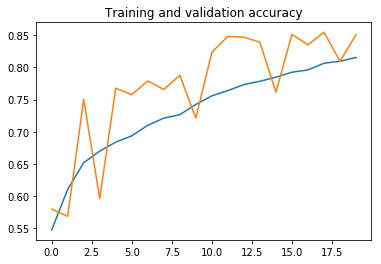

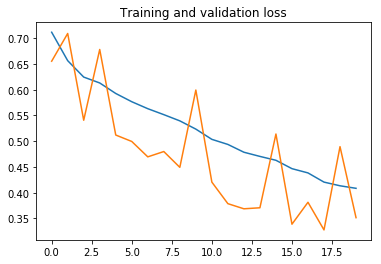

In [25]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [35]:
%%time

# preparing testing data
test_filenames = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'id': test_filenames
})

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    TEST_DIR, 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

yhat = model.predict_generator(test_generator, steps=np.ceil(TEST_SIZE/BATCH_SIZE))

Found 12500 validated image filenames.
CPU times: user 18 s, sys: 1.06 s, total: 19.1 s
Wall time: 16.6 s


In [36]:
# sigmoid returns probability between 0 and 1, need to convert it to an integer class
#yhat = [1 if y > 0.5 else 0 for y in yhat]

test_df['label'] = yhat

# restoring back to class names (dog|cat)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)

# encoding according to submission format, 1 = dog, 0 = cat
test_df['label'] = test_df['label'].replace({ 'dog': 1, 'cat': 0 })

test_df['id'] = test_df['id'].str.split('.').str[0]

test_df.to_csv('submission.csv', index=False)

In [37]:
!head submission.csv

id,label
7803,0.963197648525238
2752,0.9886592030525208
96,0.026650508865714073
4336,0.9509921669960022
5821,0.997200608253479
10991,0.7990306615829468
909,0.8441784381866455
12046,0.9266053438186646
12367,0.9103294014930725


In [38]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f submission.csv -m "testing API submission"

100%|████████████████████████████████████████| 296k/296k [00:04<00:00, 73.4kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition